# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pandas as pd
from astroquery.splatalogue import Splatalogue  # We must acknowledge authors for use of this library
from astropy import units as u
from SpectralQuery import SpectralQuery
import pickle

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!


# Data
The data comes from 4 text files.  Each file contains 2 columns of data, _frequency_ and _flux_.  This will get stored in a list so that we can access them one by one.

A np.array representing all data sets will also be available.  The units here are converted to MHz for consistency with return results from Splatalogue, CDMS, and JPL databases.  We also identify the min and max frequency of each data set here since the data may not be continuous across every file.

At various points during development, files will be written to the local hard drive in order to reduce processing time on subsequent runs of this notebook.  The all_molecules.csv file contains the information necessary to skip the `find_molecules` function.  The spectral_lines.pkl file contains the CDMS and JPL database entries for each molecule of interest and once read in, allows us to skip the portion of code that generates it (~10 minutes of processing).  The spectral_complete.pkl file contains all information necessary for analysis to proceed.

In [2]:
# read in the data
print("\n--- Reading in data ---")
filenames = ["./Data/Win0.clean1.contsub_Jy.rest.scom.c.txt",
             "./Data/Win1.clean1.contsub_Jy.rest.scom.c.txt",
             "./Data/Win2.clean1.contsub_Jy.rest.scom.c.txt",
             "./Data/Win3.clean1.contsub_Jy.rest.scom.c.txt"]
# 'data' will be a 4 element list, with each element representing the data from 1 text file
data = [np.loadtxt(f) for f in filenames]
full_data = np.concatenate(data)  # One giant numpy array containing all the data
full_data[:,0] = np.round(full_data[:,0] * 1000, 5)  # Frequences in MHz rounded to 5 decimal places
# Create empty lists for the min and max frequency of the data
min_freqs = []
max_freqs = []    
# Determine the min and max frequency (in MHz) in each dataset    
for dataset in data:
    # Each dataset provided has a different min and max frequency.  We need to find them all.
    min_freqs.append(dataset[0][0] * 1000)
    max_freqs.append(dataset[-1][0] * 1000)
generate_plot = True
print("--- Complete ---\n")

# Read in all_molecules if it exists
if os.path.isfile('./Data/all_molecules.csv'):
    print("\n--- Loading in all_molecules ---")
    all_molecules = pd.read_csv('./Data/all_molecules.csv', header = 0, index_col = 0).to_dict(orient = "index")
    generate_plot = False   # Whether or not to generate the plot
    print("--- Complete ---\n")

# read in spectral_lines if it exists   
if os.path.isfile('./Data/spectral_lines.pkl'):
    print("\n--- Loading in spectral_lines ---")
    with open('./Data/spectral_lines.pkl', 'rb') as file:
        spectral_lines = pickle.load(file)
    spectral_lines = {key: pd.DataFrame.from_dict(value, dtype = np.float64) for key, value in spectral_lines.items()}
    print("--- Complete ---\n")

# read in spectral_complete if it exists   
if os.path.isfile('./Data/spectral_complete.pkl'):
    print("\n--- Loading in spectral_complete ---")
    with open('./Data/spectral_complete.pkl', 'rb') as file:
        spectral_complete = pickle.load(file)
    spectral_complete = {key: pd.DataFrame.from_dict(value).astype({"frequency": np.float64, 
                                                                    "uncertainty": np.float64,
                                                                    "intensity": np.float64,
                                                                    "closest": np.float64,
                                                                    "acceptable": bool,
                                                                    "flux": np.float64,
                                                                    "spike": bool}) for key, value in spectral_complete.items()}
    print("--- Complete ---\n")


--- Reading in data ---
--- Complete ---


--- Loading in all_molecules ---
--- Complete ---


--- Loading in spectral_lines ---
--- Complete ---



## Functions

### create_plot()
This function will generate a figure with 4 axes and produce a plot of the frequency versus flux of the raw data.  It will then return the figure and handle to those axes.

In [3]:
def create_plot():
    """ Recreate the plot from Cordiner et. al. 2015, Figure 1 """
    # Defining the figure might need more finess if there are more than 4 datasets
    # We need to consult a domain expert to learn if ALMA data always comes back with 4 datasets
    fig, axs = plt.subplots(2, 2, figsize = (10, 6))
    for index, ax in enumerate(axs.flat):
        # Plot each data set
        ax.plot(data[index][:,0],
                data[index][:,1],
                linewidth = 0.25)
        ax.set(ylabel = "Flux (Jy)")
        ax.set(xlabel = "Frequency (GHz)")
        # Clean up the xticks
        ax.set_xticks(np.arange(round(data[index][0,0], 1), round(data[index][-1,0], 1), step = 0.5))
        # Remove the space from the borders of the plot along the X axis
        ax.autoscale(enable = True, axis = 'x', tight = True)
    # Add some space between the plots
    plt.subplots_adjust(hspace = .3, wspace = .3)
    return fig, axs

### add_lines(id, molecules)
This function adds dashed lines to a specified axis (`id`) at every frequency passed in by `molecules`.  `molecules` is a dictionary whose keys are the _frequencies_ above the 3$\sigma$ threshold and whose values are the _Chemical names_ of molecules that have a spectral line at that frequency, and also their _Molecule Tag_.  So each frequency will have a dictionary inside it with keys _Chemical Name_ and _Molecule Tag_ with values pulled from the results of a Splatalogue query.

In [4]:
def add_lines(id, molecules):
    """This function will add dashed lines to the plot where molecules were detected"""
    for freq in molecules.keys():
        axs[id].axvline(x = float(freq),
                        ymin = 0,
                        ymax = 1,
                        dashes = [18, 6],
                        linewidth = 0.25,
                        color = "gray",
                        alpha = 0.5)

### find_molecules(all_molecules)
This function constructs 2 dictionaries.  The first dictionary created is `molecules.`  `molecules` is a dictionary whose keys are the _frequencies_ above the 3$\sigma$ threshold and whose values are the _Chemical names_ of molecules that have a spectral line at that frequency, and also their _Molecule Tag_.  So each frequency will have a dictionary inside it with keys _Chemical Name_ and _Molecule Tag_ with values pulled from the results of a Splatalogue query.  `molecules` is unique to each axis on the figure.  That is, since there are 4 axes on the figure, `molecules` gets generated 4 times.  Each time those frequencies get passed to `add_lines(id, molecules)` along with the `id` of the axis that it is meant for.

The second dictionary is a global dictionary, `all_molecules`.  This dictionary's keys are the unique _Chemical Names_ identified from all 4 generations of the `molecules` dictionary.  The values are another dictionary with keys _Occurances_, _Molecule Tag_, and _Linelist_ whose values are the frequencies of spectral emissions this molecule was found at in the data, the molecule tag number, and the linelist representing what database the data was pulled from, respectively.

The `molecules` dictionary is generated by first identifying all frequencies where the flux exceeds the 3$\sigma$ threshold (where a flux value is greater than 3 standard deviations away from the mean).  Then, for each frequency that meets this criteria, a query to the Splatalogue API is made at that frequency $\pm$ some `delta` (initially set to 50kHz).  If the query returns any results, they are added to the `molecules` and `all_molecules` dictionarys.

In [5]:
def find_molecules(all_molecules):
    """ Classify the molecules from their frequency for each dataset """
    for id, dataset in enumerate(data):
        # Determine the standard deviation of the data with signals removed
        # --- WE COULD INCORPORATE THE WORKS OF https://iopscience.iop.org/article/10.1086/679285/pdf HERE!!! ---
        moch_data = dataset.copy()
        moch_data[np.where( moch_data[:, 1] >= 5 * np.std(moch_data[:, 1])), 1] = 0  # 0's fluxs >= 5 stddevs
        # Locate the indices where the flux is greater than 3 standard deviations
        # There are 4 datasets.  Column 0 is the frequency, column 1 is the flux
        # Splatalogue appears to be accurate up to 5 decimal places
        molecules = {}  # An empty dictionary to store the results of each detected molecule and rest frequency
        delta = dataset[1][0] - dataset[0][0] # +/- when searching frequencies
        frequencies = np.round(dataset[np.where( dataset[:, 1] >= 3 * np.std(moch_data[:, 1])), 0], 5)[0]
        for freq in frequencies:
            # Query Splatalogue at each frequency +/- delta using the CDMS and JPL databases
            results = Splatalogue.query_lines( (freq - delta)*u.GHz, (freq + delta)*u.GHz,
                                                show_molecule_tag = True,
                                                top20 = 'planet',
                                                line_lists = ['CDMS', 'JPL'],
                                                line_strengths = 'ls1')
            # Append the chemical names corresponding to the searched frequency.
            if len(results) > 0:
                molecules[freq] = {"Chemical Name": results["Chemical Name"].tolist(),
                                   "Molecule Tag": results["Molecule<br>Tag"].tolist()}
            else:
                molecules[freq] = {"Chemical Name": "Unknown",
                                   "Molecule Tag": None}
        
            # Append the chemical name and frequency to the dictionary of all molecules found
            if len(results) > 0:
                for i, molecule in enumerate(results["Chemical Name"].tolist()):
                    if molecule in all_molecules.keys():
                        all_molecules[molecule]["Occurances"].append(freq)
                    else:
                        # Add leading 0's to the Molecule Tag if it's less than 6 characters
                        molecule_tag = "0" + str(results["Molecule<br>Tag"][i]) if len(str(results["Molecule<br>Tag"][i])) < 6 else str(results["Molecule<br>Tag"][i])
                        # You might find a '-' for the first character.  If so, change it to a 0
                        if "-" in molecule_tag: molecule_tag = "0" + molecule_tag[1:]
                        # The molecule is new.  Add its tag, linelist, and frequency to all_molecules
                        all_molecules[molecule] = {"Molecule Tag": molecule_tag,
                                                   "Linelist": results["Linelist"][i],
                                                   "Occurances": [freq]}
            else:
                # If the query returns no results, then we've found a significant emmission frequency with
                # no known molecule associated with it.
                if "Unknown" in all_molecules.keys():
                    all_molecules["Unknown"]["Occurances"].append(freq)
                else:
                    all_molecules["Unknown"] = {"Molecule Tag": "None",
                                                "Linelist": "None",
                                                "Occurances": [freq]}
        add_lines(id, molecules)
    return all_molecules

### pull_spectral_lines(spectral_lines)

Once all the molecules that could be in the data have been identified, we can then query other databases (**CDMS** and **JPL**) to retrieve the complete set of every spectral line emmission frequency for each identified molecule.  To do this, we need to know what `molecule_tag` to search for along with the database (_linelist_) it came from.

The `SpectralQuery` library will do exactly this.  By supplying the _linelist_ to a `SpectralQuery` class object, and the `molecule_tag`, it will scrape the spectral emmisssion data from the appropriate web page and store it in a pandas data frame.  Since we don't know exactly how many queries we'll need to make, and since the number of rows each query returns is also unknown, the results are best saved in a dictionary for further usage.  The global dictionary `spectral_lines` will be constructed with this function.  Its keys will be the _Chemical Names_ from `all_molecules`, and its values will be the results returned from `SpectralQuery.getSpectralLines()`.

In [6]:
def pull_spectral_lines(spectral_lines):
    """Scrapes the given database for the spectral lines emmitted by the molecule with the specified molecule_tag"""
    print("Retrieving spectral line frequencies for molecules of interest...")
    for molecule in all_molecules.keys():
        # Viable Linelist options are "CDMS, JPL, or None."  If "None" (for "Unknown"), just pass
        if all_molecules[molecule]["Linelist"] == "CDMS":
            cdms.getSpectralLines(all_molecules[molecule]["Molecule Tag"])
            spectral_lines[molecule] = cdms.lines
        elif all_molecules[molecule]["Linelist"] == "JPL":
            results = jpl.getSpectralLines(all_molecules[molecule]["Molecule Tag"])
            spectral_lines[molecule] = jpl.lines
        else:
            continue
    spectral_lines = {key: pd.DataFrame.from_dict(value, dtype = np.float64) for key, value in spectral_lines.items()}
    return spectral_lines
    print("Done\n")

## Generate Queries

Run the functions necessary to generate all the data required.

In [7]:
# Generte the plot if necessary
if generate_plot:
    fig, axs = create_plot()
    axs = axs.flat

# If all_molecules wasn't loaded in, generate and save it by running the find_molecules function
if "all_molecules" not in locals():
    all_molecules = {}  # This will store the molecule name and every frequency it is found at
    all_molecules = find_molecules(all_molecules)
    
    # Save the all_molecules dictionary
    pd.DataFrame.from_dict(all_molecules,
                           columns = ["Molecule Tag",
                                      "Linelist",
                                      "Occurances"],
                           orient = "index").to_csv("./Data/all_molecules.csv")
    
# If spectral_lines wasn't loaded in, generate and save it by running the pull_spectral_lines function
if "spectral_lines" not in locals():
    # Define the dictionary 'spectral_lines'
    spectral_lines = {}
    # Scrape the CDMS Database content
    print("Parsing the Cologne Database for Molecular Spectroscopy...")
    cdms = SpectralQuery("CDMS")
    print("Done\n")
    # Scrape the JPL Database content
    print("Parsing the Jet Propulsion Laboratory Molecular Spectroscopy Database...")
    jpl  = SpectralQuery("JPL")
    print("Done\n")
    # Iterate through each molecule in all_molecules to pull all their emmission frequencies
    spectral_lines = pull_spectral_lines(spectral_lines)
    # Discard entries that are outside the bounds of our data [min_freq, max_freq]
    all_spectral_lines = spectral_lines.copy()
    # Save the spectral_lines dictionary
    with open('./Data/spectral_lines.pkl', 'wb') as file:
        pickle.dump(spectral_lines, file, protocol = pickle.HIGHEST_PROTOCOL)
    print("Done\n")

# Output

## View the Raw Data
A plot of every data set on a single axis reveals if there are gaps if frequency between data sets

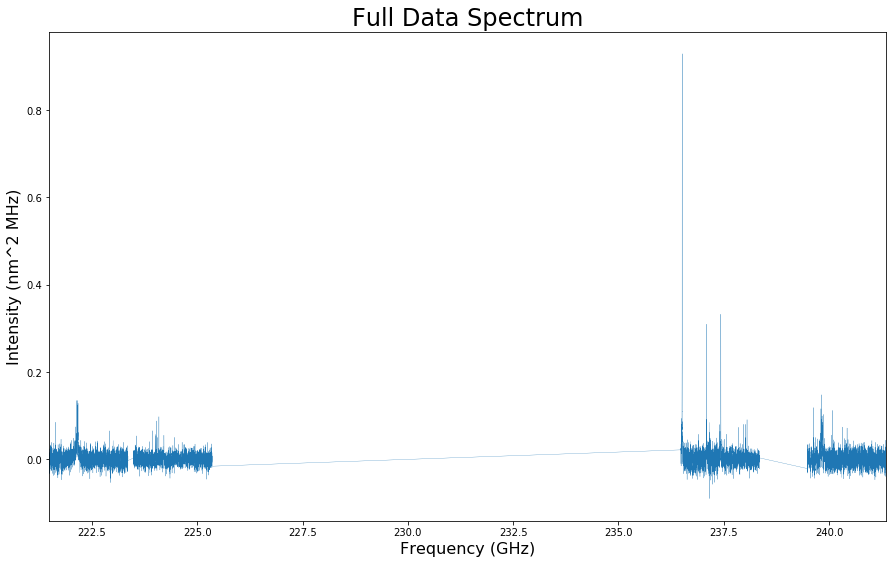

In [8]:
fig2, ax2 = plt.subplots(figsize = (15, 9))
# Plot the data
ax2.plot(full_data[:, 0] / 1000,
         full_data[:, 1],
         linewidth = 0.25)
ax2.set(title = "Full Data Spectrum")
ax2.set(ylabel = "Intensity (nm^2 MHz)")
ax2.set(xlabel = "Frequency (GHz)")
ax2.title.set_size(24)
ax2.yaxis.label.set_size(16)
ax2.xaxis.label.set_size(16)
ax2.autoscale(enable = True, axis = 'x', tight = True)

## View all_molecules and Plot

Simply change show_plot to True to see the plot, and show_output to True to see the dictionary of all molecules.

In [9]:
# Specify output to show
show_plot = False   # Whether or not to show the plot
show_output = True  # Whether or not to view the all_molecules dictionary


# Generate the plot 
if show_plot:
    fig, axs = create_plot()
    axs = axs.flat
    new_plot = find_molecules({})

# Output all_molecules in an easily readable table format.
if show_output:
    print("{:<15} {:<15} {:<10} Occurances".format('Molecule','Molecule Tag','Linelist'))
    for molecule, values in all_molecules.items():
        tag = all_molecules[molecule]["Molecule Tag"]
        linelist = all_molecules[molecule]["Linelist"]
        occurances = all_molecules[molecule]["Occurances"]
        print("{}".format(molecule))
        print("{:<15} {:<15} {:<10} {}".format("", tag, linelist, occurances))

Molecule        Molecule Tag    Linelist   Occurances
&alpha;-Alanine
                089503          CDMS       [222.1301, 222.1301, 222.13059, 222.13059, 222.16135, 222.16184, 222.1677, 222.16819, 222.91873, 224.00182, 224.00182, 224.00231, 224.00231, 224.0028, 224.00329, 236.50327, 236.50376, 236.50913, 236.50962, 236.51011, 236.51011, 236.5106, 236.5106, 236.51597, 236.51597, 236.51646, 236.51646, 237.43156, 237.43205, 237.43205, 237.43254, 237.43303, 237.43351, 237.43351, 237.43351, 237.43351, 237.43351, 237.434, 237.434, 237.434, 237.434, 239.6832]
1,2-propanediol, aG'g
                076513          CDMS       [222.12961, 222.1301, 222.16184, 222.16233, 223.93395, 223.93395, 225.23629, 225.23629, 225.23629, 225.23629, 237.0912, 237.09218, 237.09267, 237.09365, 237.09413, 239.83507, 239.83556, 240.08997, 240.09046]
1,2-propanediol, g'G'g
                076516          CDMS       [222.10031, 222.1008, 222.15158, 222.15354, 222.15403, 223.86705, 223.93297, 223.93346, 223.93395, 2

## Sample Output of spectral_lines
To get an idea of how wide the frequency space is that a given molecule emits spectral lines at, let's examine Ethyl Cyanide from the Cordiner et al. 2015 paper.  By plotting all the frequencies and intensities obtained the JPL database, we can see where Ethyl Cyanide not only peaks, but also the fraction of that space captured by the ALMA telescope.

**NOTE**: THIS CODE CHUNK TAKES APPROXIMATE 1.5 HOURS TO COMPLETE!  ONLY RUN IF NECESSARY!

In [10]:
#import matplotlib.patches as patches
#fig2, ax2 = plt.subplots(figsize = (15, 9))
## Plot each data set
#(markers, stemlines, baseline) = ax2.stem(all_spectral_lines["Ethyl Cyanide"]["frequency"],
#                                          10 ** all_spectral_lines["Ethyl Cyanide"]["intensity"],
#                                          markerfmt = "none")
#plt.setp(stemlines, linestyle = "-", color = "blue", linewidth = 0.25 )
#plt.setp(baseline, visible = False)
#ax2.set(title = "Ethyl Cyanide Spectral Emissions")
#ax2.set(ylabel = "Intensity (nm^2 MHz)")
#ax2.set(xlabel = "Frequency (MHz)")
#ax2.title.set_size(24)
#ax2.yaxis.label.set_size(16)
#ax2.xaxis.label.set_size(16)
#rect = patches.Rectangle(xy = (min_freq, 0),
#                         width = max_freq - min_freq, 
#                         height = ax2.get_ylim()[1], 
#                         fill = False,
#                         color = 'red',
#                         linewidth = 2)
#ax2.add_patch(rect)
#ax2.set_ylim(0, ax2.get_ylim()[1])
#ax2.autoscale(enable = True, axis = 'x', tight = True)

# Analysis

At this stage, we know all the possible molecules that _could_ be in the data, and we know all spectral line frequencies and intensities that those molecules emit at in the range of our data.  The next step is to classify whether or not a particular molecule is present in the data.

One method is to examine how many of the strongest intensity spectral lines exceed the 3$\sigma$ threshold in the data.  The more spectral lines there are that meet this criteria, the greater our confidence is that the molecule is present.

## Preprocessing

In [11]:
# Some frequencies in spectral_lines are duplicated.  Remove those first.
for molecule in spectral_lines.keys():
    spectral_lines[molecule] = spectral_lines[molecule].sort_values('frequency', ascending=False)
    spectral_lines[molecule].drop_duplicates(subset = "frequency", keep = "first", inplace = True)
    spectral_lines[molecule] = spectral_lines[molecule].sort_values(by = "intensity", ascending = False)

## Functions

### closest_freq(spectral_frequencies, data_frequencies)

The frequencies listed in `spectral_lines` frequency column may not match up exactly to the frequencies found in our data.  For that reason, we need to find the closest frequency in our input data to each frequency in the `spectral_lines` data.  That is, for every known spectral emission frequency in `spectral_lines`, there is a frequency bin in the input data that is _closest_ to it.

An important thing to note about this function is that the units of data_frequencies and spectral_frequencies **must** match.  For this reason, `full_data` is already converted from GHz to MH.

In [12]:
def closest_freq(spectral_frequencies, data_frequencies):
    # Convert the pd.Series to a list
    spectral_frequencies = spectral_frequencies.tolist()
    # We'll also need an array of zeros to store the results
    closest_ids = np.zeros(len(spectral_frequencies), dtype = int)
    # Then, for each spectral frequency, find the frequency in the input data closest to it.
    for i, freq in enumerate(spectral_frequencies):
        # Take the absolute value of the data_frequencies - spectral_frequency
        # This will generate an array of values.  The smallest value is the closest frequency
        closest_ids[i] = (np.abs(data_frequencies - freq)).argmin()
    # Finally, return the array of indices
    return closest_ids

## find_matches(spectral_lines)

This function will add some columns to the pandas dataframe for each molecule.  The first column it adds is "closest" which represents the frequency in the input data that is closest to the frequency obtained from CDMS or JPL.  The next column is "acceptable" which returns True if the absolute value of the difference between "closest" and "frequency" is less than or equal to the "uncertainty."

In [13]:
def find_matches(spectral_lines):
    for molecule in spectral_lines.keys():
        # bounds will contain the indices of spectral_lines where the data is within all the mins and maxs
        # First, initialize bounds to have the indices of the data between the min and max of the first dataset
        bounds = np.array(np.where( (spectral_lines[molecule]["frequency"] >= min_freqs[0]) &
                                    (spectral_lines[molecule]["frequency"] <= max_freqs[0])  ) )
        # Then append to it the indices of spectral_lines where the data is within the remaining mins and maxs
        for idx in range(1, len(min_freqs)-1):
            bounds = np.append(bounds, np.where( (spectral_lines[molecule]["frequency"] >= min_freqs[idx]) &
                                                 (spectral_lines[molecule]["frequency"] <= max_freqs[idx])  ) )
        # Finally, restrict spectral_lines to only those entries contained in bounds.
        spectral_lines[molecule] = spectral_lines[molecule].iloc[bounds]
        
        # Find the indices of the closest frequencies to those in the CDMS/JPL data
        closest_frequencies = closest_freq(spectral_lines[molecule]["frequency"], full_data[:, 0])
        # Assign the frequency at the identified indices to a new column in spectral_lines
        spectral_lines[molecule]["closest"] = full_data[closest_frequencies, 0]
        spectral_lines[molecule]["acceptable"] = True
        spectral_lines[molecule]["acceptable"].iloc[np.where(np.abs(spectral_lines[molecule].closest - 
                                                          spectral_lines[molecule].frequency) > 
                                                   spectral_lines[molecule].uncertainty)] = False
        spectral_lines[molecule]["flux"] = full_data[closest_frequencies, 1]
        spectral_lines[molecule]["spike"] = False
        for idx, dataset in enumerate(data):
            moch_data = dataset.copy()
            moch_data[np.where( moch_data[:, 1] >= 5 * np.std(moch_data[:, 1])), 1] = 0  # 0's fluxs >= 5 stddevs
            spectral_lines[molecule]["spike"].iloc[
                np.where( (spectral_lines[molecule].frequency >= min_freqs[idx]) &
                          (spectral_lines[molecule].frequency <= max_freqs[idx]) &
                          (spectral_lines[molecule].flux >= 3 * np.std(moch_data[:, 1]))
                        )[0]] = True
        spectral_lines[molecule] = spectral_lines[molecule].sort_values(by = "intensity", ascending = False)
    return spectral_lines

## Refine the Data

In [14]:
if "spectral_complete" not in locals():
    # Define the dictionary 'spectral_complete'
    # Iterate through each molecule in spectral_lines and determine if spikes are present in the input data
    print("Refining spectral_lines...")
    spectral_complete = find_matches(spectral_lines)
    # Save the spectral_complete dictionary
    with open('./Data/spectral_complete.pkl', 'wb') as file:
        pickle.dump(spectral_complete, file, protocol = pickle.HIGHEST_PROTOCOL)
    print("Done\n")

Refining spectral_lines...


c:\users\andrew\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Done



In [16]:
spectral_complete["Ethyl Cyanide"][spectral_complete["Ethyl Cyanide"]["spike"] == True]

,frequency,uncertainty,intensity,closest,acceptable,flux,spike
5333,237851.8593,0.0020,-2.6292,237852.00069,False,0.073258,True
5318,237405.1700,0.0500,-2.6362,237405.19192,True,0.079531,True
5312,237170.4500,0.0500,-2.6460,237170.31212,False,0.084396,True
4914,223553.6100,0.0500,-2.6706,223553.55049,False,0.053545,True
4900,222918.1747,0.0021,-2.6855,222918.23940,False,0.065100,True
4922,223933.7301,0.0020,-2.6963,223933.94834,False,0.056556,True
5000,225236.1184,0.0020,-2.7076,225236.28603,False,0.038670,True
4971,224638.7008,0.0020,-2.7098,224638.58774,False,0.038925,True
4962,224458.8563,0.0020,-2.7312,224458.88760,False,0.050238,True
4950,224208.0832,0.0019,-2.7578,224207.89339,False,0.051239,True
